In [50]:
import torch
import os, sys
import h5py
from models.genutils import *
from config import *
import numpy as np
from models.v2pca import *
from utils import *
import matplotlib
import matplotlib.pyplot as plt
from data_loader import matfile_dataload, h5py_dataload
from torch.optim import SGD
from dimred import *
from sklearn.manifold import TSNE
np.set_printoptions(suppress=True)
%matplotlib inline
np.random.seed(5)
%config IPCompleter.greedy=True



In [2]:
datadir  = '/scratch/np1742/texture-modeling/dat/'
outputdir = './output/'
imsize='384'
imagefile = 'cropped'+ imsize +'-gray-jpg_40_4000.h5'
imarr1 = h5py.File(datadir+imagefile, 'r')['dat'][0:10000]
indsarr1 = h5py.File(datadir+imagefile, 'r')['inds'][0:10000]
if imsize == '512':
    wood = [4,18,39]
    brick = [3,21]
    stone = [0,20]
    grass = [27,28,29] 
    #32,33]
    total_inds = [4,0,3,27]
    labels = ['wood', 'stone', 'grass']

elif imsize == '384':
    wood = [31,33]
    brick = [6]
    stone = [12,19]
    grass = [34,39]
    total_inds = [31,19,3]
    labels = ['wood', 'stone', 'grass']
    
texturetypedict = {'wood': wood, 'brick': brick, 'stone': stone, 'grass': grass, 'all': total_inds}
dimreduce_type = 'geneig'

matdata = matfile_dataload(rawdat = True)
window = np.array(matdata['data'][0][0]['f'][0][0]['coeffWeights'])
windowbool = np.array(matdata['data'][0][0]['f'][0][0]['coeffIndex'])[:,0]
windowinds = np.nonzero(windowbool)[0]
window = torch.tensor(window, dtype=dtype).to(device)
imname = imagefile.rstrip('.h5')



no
(10000, 20)
yes
Computing svd for pca...
Tsne done...
no
(10000, 20)
yes
Computing svd for pca...
Tsne done...
4


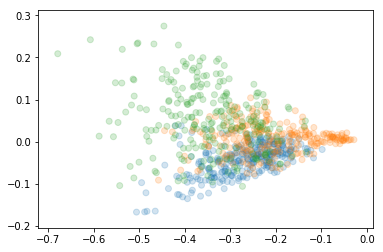

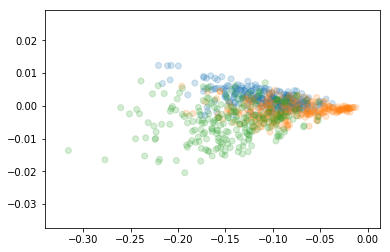

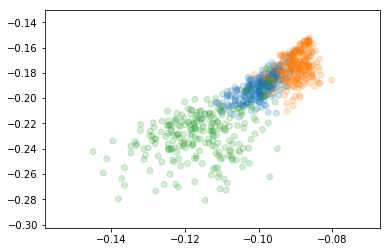

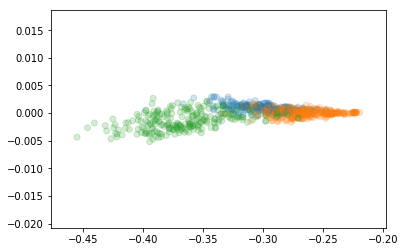

In [4]:
def get_texture_type(componentfile, texture_type, texturetypedict, squared=True, tsne=True):
    x = h5py.File(componentfile, 'r')['dat'][()]
    if squared:
        compname = componentfile.rstrip('.h5')
        #x = np.concatenate(x,np.sqrt(x**2))
        #x = x**2
        x = np.concatenate((x, x**2), axis=1)
        h5f = h5py.File(compname + '_square.h5', 'w')
        h5f.create_dataset('dat', data=x, compression = 'gzip')
        h5f.close()
        print(x.shape)

    if texture_type == 'all' and squared:
        print("yes")
        #X_embedded = TSNE(n_components=2).fit_transform(x)
        #PC = PCA(torch.tensor(x), n_components = 10)
        #print(PC.size())
        X_embedded = np.dot(x, PC.data.cpu().numpy())
        print('Tsne done...')
    else:
        print("no")
        X_embedded = x
    imlist = texturetypedict[texture_type]
    colorval = 0
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    for i in range(len(imlist)):
        n = imlist[i]
        colorval +=1

        indsval = np.where(indsarr1 == n)[0]
        xout = x[indsval,:]
        xembedtmp = X_embedded[indsval,:]
        imtmp = imarr1[indsval]
        indstmp = indsarr1[indsval]
        colorvals = [colors[colorval-1] for i in range(len(indsval))]
        if i == 0:
            imarr = imtmp
            xarr = xout
            xembed = xembedtmp
            indsarr = indstmp
            colorinds = colorvals

        else:
            imarr = np.concatenate((imarr, imtmp), axis=0)
            indsarr = np.concatenate((indsarr,indstmp))
            xarr = np.concatenate((xarr,xout), axis=0)
            xembed = np.concatenate((xembed,xembedtmp), axis=0)
            colorinds.extend(colorvals)

    
    if texture_type is not 'all':
        covarr = np.cov(xarr.T)
        meanarr = np.mean(xarr, axis=0)
        mvn = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor(meanarr, dtype=dtype), torch.tensor(covarr, dtype=dtype))
    else:
        mvn = None
    
    return imarr, xarr, xembed, mvn, indsarr, colorinds

finalims = []
finalembed = []
finaltext = []
finalcolorinds = []
finalinds = []
for dimreduce_type in ['pca', 'geneig']:

    if dimreduce_type == 'pca':
        weightfile = outputdir + 'pca_cropped'+imsize+'-gray-jpg_40_4000.h5'
        componentfile =  outputdir + 'pca_cropped' + imsize + '_componenttest_40_4000_10000.h5'
    elif dimreduce_type == 'geneig':
        weightfile = outputdir + 'geneigtransform_cropped'+imsize+'-gray-jpg_40_4000.h5'
        componentfile = outputdir + 'geneigtransform_cropped' + imsize + '_componenttest_40_4000_10000.h5'
    elif dimreduce_type =='sgdgeneig':
        weightfile = outputdir + 'sgdgeneigtransform_cropped'+imsize+'-gray-jpg_40_4000.h5'
        componentfile = outputdir + 'sgdgeneigtransform_cropped' + imsize + '_componenttest_40_4000_10000.h5'

    



#grassim, grasstext, _, mvngrass, grassinds, _ = get_texture_type(componentfile, 'grass', texturetypedict)
#brickim, bricktext, _, mvnbrick, brickinds, _ = get_texture_type(componentfile, 'brick', texturetypedict)
#woodim, woodtext, _, mvnwood, woodinds, _ = get_texture_type(componentfile, 'wood', texturetypedict)
#stoneim, stonetext, _,  mvnstone, stoneinds, _ = get_texture_type(componentfile, 'stone', texturetypedict)
    allim1, alltext1,allembed1, _, allinds1, colorinds1 = get_texture_type(componentfile, 'all', texturetypedict, squared = False, tsne=False)
    allim2, alltext2,allembed2, _, allinds2, colorinds2 = get_texture_type(componentfile, 'all', texturetypedict, squared = True, tsne = False)
    finalims.append(allim1)
    finalims.append(allim2)
    finaltext.append(alltext1)
    finaltext.append(alltext2)
    finalembed.append(allembed1)
    finalembed.append(allembed2)
    finalcolorinds.append(colorinds1)
    finalcolorinds.append(colorinds2)

#print(grasstext.shape)
#print(grassim.shape)
#print(allinds[0:20])

i = 0
print(len(finaltext))
for embed in finalembed:
    plt.figure()
    if i == 0 or i == 1:
        ind1 = 0
        ind2 = 1
    if i > 1:
        ind1 = 0
        ind2 = 1
    plt.scatter(embed[:,ind1],embed[:,ind2], c=colorinds1, marker="o", alpha=0.2)
    plt.show()
    i = i+1



In [ ]:
finalims = []
finalembed = []
finaltext = []
finalcolorinds = []
finalinds = []
for dimreduce_type in ['pca', 'geneig']:

    if dimreduce_type == 'pca':
        weightfile = outputdir + 'pca_cropped'+imsize+'-gray-jpg_40_4000.h5'
        componentfile =  outputdir + 'pca_cropped' + imsize + '_componenttest_40_4000_10000.h5'
    elif dimreduce_type == 'geneig':
        weightfile = outputdir + 'geneigtransform_cropped'+imsize+'-gray-jpg_40_4000.h5'
        componentfile = outputdir + 'geneigtransform_cropped' + imsize + '_componenttest_40_4000_10000.h5'
    elif dimreduce_type =='sgdgeneig':
        weightfile = outputdir + 'sgdgeneigtransform_cropped'+imsize+'-gray-jpg_40_4000.h5'
        componentfile = outputdir + 'sgdgeneigtransform_cropped' + imsize + '_componenttest_40_4000_10000.h5'

    



#grassim, grasstext, _, mvngrass, grassinds, _ = get_texture_type(componentfile, 'grass', texturetypedict)
#brickim, bricktext, _, mvnbrick, brickinds, _ = get_texture_type(componentfile, 'brick', texturetypedict)
#woodim, woodtext, _, mvnwood, woodinds, _ = get_texture_type(componentfile, 'wood', texturetypedict)
#stoneim, stonetext, _,  mvnstone, stoneinds, _ = get_texture_type(componentfile, 'stone', texturetypedict)
    allim1, alltext1,allembed1, _, allinds1, colorinds1 = get_texture_type(componentfile, 'all', texturetypedict, squared = False, tsne=False)
    #allim2, alltext2,allembed2, _, allinds2, colorinds2 = get_texture_type(componentfile, 'all', texturetypedict, squared = False, tsne = False)
    finalims.append(allim1)
    finaltext.append(alltext1)
    finalembed.append(allembed1)
    finalcolorinds.append(colorinds1)


In [ ]:
indplot = np.random.randint(0,779,size=500)
for embed in finalembed:
    plt.figure()
    colorindslist = np.array(colorinds1)
    colorindslist = list(colorindslist[indplot])
    plt.scatter(embed[indplot,0],embed[indplot,1], c=colorindslist, marker="o", alpha=0.2)
    plt.show()

In [ ]:
colorinds1.shape

In [ ]:
#make phase scrambled
imarr_ps = np.zeros_like(imarr1)
for i in range(imarr1.shape[0]):
    image = imarr1[i,:,:]
    F = np.fft.fft2(image)
    F_mag = np.abs(np.fft.fftshift(F))
    F_phase = np.angle(np.fft.fftshift(F))
    Fnew_phase = 2.0*math.pi*np.random.rand(F_phase.shape[0], F_phase.shape[1])
    Fnew = F_mag*np.exp(1j*Fnew_phase)
    fnew = np.fft.ifft2(np.fft.ifftshift(Fnew))
    imarr_ps[i,:,:] = np.real(fnew)


h5f = h5py.File(datadir + imname + '_ps.h5', 'w')
h5f.create_dataset('dat', data=imarr_ps, compression = 'gzip')
h5f.close()
    


In [ ]:
fig, axs = plt.subplots(1,4, figsize=(15,5))
ims = [grassim[2,:,:], woodim[2,:,:], stoneim[2,:,:], brickim[2,:,:]]
minval = min([im.min() for im in ims])
maxval = max([im.max() for im in ims])
for i in range(4):
    im = window_im(ims[i], window)
    axs[i].imshow(im, cmap='gray', vmin=minval, vmax = maxval)
    axs[i].set_title(str(i))
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)
    
plt.show()

In [ ]:
samps = mvnbrick.rsample(torch.Size((100,1)))
log_prob_brick = mvnbrick.log_prob(samps)
log_prob_grass = mvngrass.log_prob(samps)
log_prob_wood = mvnwood.log_prob(samps)
log_prob_stone = mvnstone.log_prob(samps)
plt.figure()
plt.scatter(log_prob_brick.data.numpy(), log_prob_grass.data.numpy(),alpha=0.75)
plt.axis('equal')
plt.xlabel('LL of Sample w.r.t Brick Dist')
plt.ylabel('LL of Sample w.r.t Grass Dist')
plt.figure()
plt.scatter(log_prob_brick.data.numpy(), log_prob_wood.data.numpy(),alpha=0.75)
plt.axis('equal')
plt.xlabel('LL of Sample w.r.t Brick Dist')
plt.ylabel('LL of Sample w.r.t Grass Dist')
plt.figure()
plt.scatter(log_prob_brick.data.numpy(), log_prob_stone.data.numpy(),alpha=0.75)
plt.axis('equal')
plt.xlabel('LL of Sample w.r.t Brick Dist')
plt.ylabel('LL of Sample w.r.t Grass Dist')



In [ ]:
def loss_fn(out, target):
    loss = torch.sum(torch.mean((out-target)**2))
    return loss

def texture_gradsynth(x, network, targvec, print_iters=400):
    """
    For a given network and input image x, optimize the pixels in x such that the output
    component values match a specified vector -- return imagelist for every 
    Generate num_steps gradient steps and return the image list
    """
    imagelist = []
    complist = []
    output_orig = network(x.clone())
    optimizer = SGD([x],lr=0.02, momentum = 0.9)
    printout(str(targvec.data.cpu().numpy()))
    for i in range(2000):
        #renormalize images to mean 0 std 1 before next gradient step
        x.data = (x.data-x.data.mean())/x.data.std()
        optimizer.zero_grad()
        output = network(x)
        loss = loss_fn(output, targvec)
        loss.backward(retain_graph=True)
        if i %print_iters ==0:
            outtmp = output.clone()
            outtmpnp = outtmp.detach().data.cpu().numpy()
            printout("Component Vector: " + str(np.around(outtmpnp, decimals=2)))
            print("Total Loss " + str(loss.data.cpu().numpy()))
            complist.append(np.around(outtmpnp,decimals=2))
            imagelist.append(x.clone())

        optimizer.step()

    return imagelist, complist

def run_gradsynth(weightfile,textclassarr, savepath = './output/', dataset = 'lcv', num_textures = 40, max_patches=5000, use_window=True):
    matdata = matfile_dataload(rawdat = True)
    if use_window:
        window = np.array(matdata['data'][0][0]['f'][0][0]['coeffWeights'])
        windowbool = np.array(matdata['data'][0][0]['f'][0][0]['coeffIndex'])[:,0]
        windowinds = np.nonzero(windowbool)[0]
        window = torch.tensor(window, dtype=dtype).to(device)
    else:
        window = None
        
    del matdata
    imsize = 64
    h5f = h5py.File(weightfile, 'r')
    weights = h5f['dat'][()][:,0:11]
    weights = torch.tensor(weights, dtype=dtype).to(device)
    network = V2PCA(imgSize=imsize, K=4, N=2, nonlin='smoothabs', window = window, pcaMat = weights, ret_pyr = False, ncomp=11)
    
    printout("Network and data loaded....")
    
    impatches = []
    
    wn_image = np.random.randn(imsize, imsize)
    
    randnum = np.random.randint(0, textclassarr.shape[0])
    targcomp = torch.tensor(textclassarr[randnum,:], dtype=dtype).to(device)
    im = wn_image
    x = torch.tensor(im.reshape([1,1,im.shape[0], im.shape[1]]), dtype=dtype).to(device)
    x.requires_grad_()
    imagelist, complist = texture_gradsynth(x, network, targcomp)
    return imagelist, complist

synthlist1, complist = run_gradsynth(weightfile, woodtext)
synthlist2, complist = run_gradsynth(weightfile, stonetext)
synthlist3, complist = run_gradsynth(weightfile, bricktext)
synthlist4, complist = run_gradsynth(weightfile, grasstext)

In [ ]:
import pyrtools as pt
synthlists = [synthlist1, synthlist2, synthlist3, synthlist4]
matdata = matfile_dataload(rawdat = True)
window = np.array(matdata['data'][0][0]['f'][0][0]['coeffWeights'])
windowbool = np.array(matdata['data'][0][0]['f'][0][0]['coeffIndex'])[:,0]
windowinds = np.nonzero(windowbool)[0]
window = torch.tensor(window, dtype=dtype).to(device)

for synthlist in synthlists:
    minval = min([im.min().data.cpu().numpy() for im in synthlist])
    maxval = max([im.max().data.cpu().numpy() for im in synthlist])
    fig, axs = plt.subplots(1,5, figsize=(15,10))

    for i in range(len(synthlist)):
        im = window_im(synthlist[i].data.cpu().numpy().reshape((64,64)), window)
        xind = int(np.floor(i/5))
        yind = int(i%5)
        axs[i].imshow(im, cmap='gray', vmin=minval, vmax = maxval)
        axs[i].set_title(str(i))
        axs[i].xaxis.set_visible(False)
        axs[i].yaxis.set_visible(False)

    plt.show()
    


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
n_clusters = 4
clusterer = KMeans(n_clusters = n_clusters, random_state = 10)
cluster_labels = clusterer.fit_predict(alltext)

In [ ]:

cluster_labels[300:600]

In [ ]:
total_inds = [4,18,39,3,21,0,20,27,28,29]
allinds[allinds==4] = 4
allinds[allinds==18] = 4
allinds[allinds==39]=4
allinds[allinds==3] = 3
allinds[allinds==21] = 3
allinds[allinds==0]=2
allinds[allinds==20]=2
allinds[allinds==27] = 1
allinds[allinds==28]=1
allinds[allinds==29]=1
print(allinds[0])
print(allinds[1000])
print(allinds[1600])
print(allinds[2000])

In [ ]:
finaltext[0].shape

In [82]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=10, algorithm = 'ball_tree').fit(finaltext[3])
distances, indices = nbrs.kneighbors(finaltext[3])

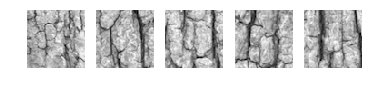

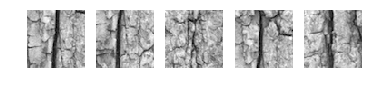

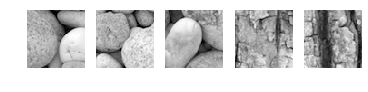

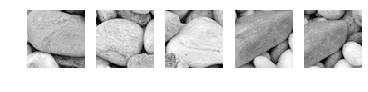

In [84]:

randints= [0,200,450,400]
for k in range(len(randints)):
    l = randints[k]
    fig, axs = plt.subplots(1,5)
    #fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

    #print(distances[l])
    
    for i in range(5):
        if i == 0:
            im = finalims[0][indices[l][i]]
        else:
            im = finalims[0][indices[l][i+1]]

            
        minval = np.min(im)
        maxval = np.max(im)
        #inds = np.where(im == 0)
        #im[inds] = 1
        xind = int(np.floor(i/5))
        yind = int(i%5)
        axs[i].imshow(im, cmap='gray')
        axs[i].axis('off')

    plt.show()
